In [1]:
# Importar librerías

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
import copy
from unet_model import construct_unet
from pathlib import Path
from PIL import Image
from imutils.paths import list_images
import os
import seaborn as sns
import pandas as pd
from datetime import datetime

# Importar Model Handler
from pv_vision.nn import ModelHandler

from pv_vision.crack_analysis.crackcell import CrackCell
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Image as RLImage, Paragraph, Spacer
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_JUSTIFY




In [15]:

# Carpeta de imágenes
imgs_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Datasets_EL/CeldasIndividuales/Mono2_V40_I5_t28'
images = [cv.imread(file) for file in list_images(imgs_path)]           #imágenes de celdas
# Verificar que las imágenes se cargaron correctamente
print(f'Número de imágenes: {len(images)}')
weight_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/PesosGColab/unetv32.pt'
out_path='D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/SalidasMonoV2'
#reporte_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Salidas'
os.makedirs(f'{out_path}/ann', exist_ok=True)
os.makedirs(f'{out_path}/image', exist_ok=True)



Número de imágenes: 60


In [23]:
### FUNCIONES


# Definir la transformación de las imágenes que se pasará al manejador del modelo
transform = transforms.Compose([
    # Convertir la imagen a un tensor de PyTorch y escalar los valores de los píxeles entre 0 y 1
    transforms.ToTensor(),
    # Normalizar cada canal de color de la imagen. 
    # Los valores de la media y la desviación estándar se especifican para cada canal (RGB). 
    # Estos valores son los valores de media y desviación estándar del conjunto de datos ImageNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Definir una clase personalizada que hereda de Dataset
class myDataset(Dataset):
    """ Clase para cargar un conjunto de datos de imágenes
    Args:
        images (list): Lista de imágenes
        transform (callable): Transformación a aplicar a las imágenes
    """
    # El método de inicialización se llama cuando se crea una instancia de la clase
    def __init__(self, images, transform):
        # Guardar las imágenes y la transformación como atributos de la instancia
        self.images = images
        self.transform = transform

    # El método __len__ devuelve el número de elementos en el conjunto de datos
    def __len__(self):
        return len(self.images)

    # El método __getitem__ se utiliza para obtener un elemento del conjunto de datos
    def __getitem__(self, idx):
        # Redimensionar la imagen al tamaño deseado
        image = cv.resize(self.images[idx], (256, 256))
        # Aplicar la transformación a la imagen
        image = self.transform(image)
        
        # Devolver la imagen transformada
        return image

# Función para obtener las máscaras de las predicciones del modelo.
def get_masks(masks_raw):
    """ Obtiene las máscaras de segmentación a partir de las predicciones del modelo.

    Args:
        masks_raw (np.ndarray): Predicciones del modelo.

    Returns:
        mask_each (list): Lista de máscaras de segmentación.
    """
    # Se creó una lista vacía para almacenar las máscaras.
    masks_each = []
    # Se aplicó la función softmax a las predicciones del modelo y se obtuvo la clase 
    # con la mayor probabilidad para cada píxel.
    masks_all = torch.nn.functional.softmax(torch.from_numpy(masks_raw), dim=1).argmax(dim=1)
    # Para cada máscara en masks_all, se crearon máscaras booleanas para cada clase 
    # y se añadieron a la lista masks_each.
    for masks in masks_all:
        busbar = masks==1
        crack = masks==2
        dark = masks==4
        masks_each.append(torch.dstack([busbar, crack, dark]).permute(2, 0, 1))
    return masks_each

# Se definió una función para dibujar las máscaras sobre las imágenes.
def draw_mask(img, masks, alpha=0.6):
    """ Dibuja las máscaras de segmentación sobre la imagen de entrada.

    Args:
        img (PIL.Image): Imagen de entrada.
        masks (list): Lista de máscaras de segmentación.
        alpha (float): Opacidad de las máscaras.

    Returns:
        PIL.Image: Imagen con las máscaras dibujadas.
    """

    # Mapa de colores para las diferentes clases de máscaras.
    colors = {
        'dark': (68, 114, 148),
        'crack': (165, 59, 63),
        'busbar': (222, 156, 83)
    }
    # Se convirtió la imagen a un objeto de la clase Image de PIL y se redimensionó.
    img = Image.fromarray(img)
    # Transformación para redimensionar las imágenes a 256x256 y convertirlas a tensores de PyTorch.
    resize = transforms.Compose([transforms.Resize((256, 256)), transforms.PILToTensor()])
    img = resize(img)
    # Se dibujaron las máscaras sobre la imagen con la opacidad especificada y se devolvió la imagen resultante.
    combo = draw_segmentation_masks(
        img, masks, alpha=alpha, colors=[colors[key] for key in ['busbar', 'crack', 'dark']]) # type: ignore
    return F.to_pil_image(combo)

# Mapas de calor de las máscaras predichas
def generate_heatmap(masks_each, class_index):
    """
    Genera un mapa de calor para una clase específica combinando todas las predicciones.

    Args:
        masks_each (list): Lista de máscaras predichas para cada imagen.
        class_index (int): Índice de la clase para la cual se desea generar el mapa de calor.
                           Por ejemplo, 0 para 'busbar', 1 para 'crack', 3 para 'dark'.

    Returns:
        np.ndarray: Mapa de calor normalizado.
    """
    # Sumar todas las máscaras correspondientes a la clase
    heatmap = np.sum([mask[class_index] for mask in masks_each], axis=0)
    
    # Normalizar el mapa de calor para que los valores estén entre 0 y 1
    #heatmap = combined_mask / combined_mask.max()
    
    return heatmap


# Función para generar y mostrar una matriz de coocurrencia
def generate_cooccurrence_matrix(masks_each, n_classes):
    """
    Genera una matriz de coocurrencia para las clases en las imágenes.

    Args:
        masks_each (list): Lista de máscaras predichas para cada imagen.
        n_classes (int): Número de clases en el conjunto de datos.

    Returns:
        np.ndarray: Matriz de coocurrencia.
    """
    cooccurrence_matrix = np.zeros((n_classes, n_classes), dtype=int)

    for masks in masks_each:
        # Convertir a NumPy si es un tensor de PyTorch
        if isinstance(masks, torch.Tensor):
            masks = masks.cpu().numpy()
        
        # Crear un conjunto de clases presentes en la imagen
        present_classes = set()
        for class_index in range(n_classes):
            if np.any(masks[class_index]):
                present_classes.add(class_index)
        
        # Actualizar la matriz de coocurrencia
        for class1 in present_classes:
            for class2 in present_classes:
                cooccurrence_matrix[class1, class2] += 1

    return cooccurrence_matrix

def save_cooccurrence_matrix(cooccurrence_matrix, class_names, file_path):
    """
    Guarda la matriz de coocurrencia en un archivo CSV.

    Args:
        cooccurrence_matrix (np.ndarray): Matriz de coocurrencia.
        class_names (list): Lista de nombres de las clases.
        file_path (str): Ruta del archivo CSV donde se guardará la matriz.
    """
    df = pd.DataFrame(cooccurrence_matrix, index=class_names, columns=class_names)
    df.to_csv(file_path)

def plot_cooccurrence_matrix(cooccurrence_matrix, class_names, save_path=None):
    """
    Visualiza la matriz de coocurrencia y opcionalmente la guarda como imagen.

    Args:
        cooccurrence_matrix (np.ndarray): Matriz de coocurrencia.
        class_names (list): Lista de nombres de las clases.
        save_path (str, optional): Ruta del archivo donde se guardará la imagen. 
        Si es None, solo muestra la matriz.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence_matrix, annot=True, fmt="d", cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 16})
    plt.xlabel('Clase')
    plt.ylabel('Clase')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Matriz de Coocurrencia', fontsize=18)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        plt.close()  # Cierra la figura para liberar memoria
    else:
        plt.show()

def generate_area_percentage_statistics(masks_each, class_names):
    """
    Genera estadísticas por imagen mostrando el porcentaje del área cubierta por cada clase.

    Args:
        masks_each (list or np.ndarray or torch.Tensor): Lista de máscaras predichas para cada imagen.
        class_names (list): Lista de nombres de las clases.

    Returns:
        pd.DataFrame: DataFrame con el porcentaje de área cubierta por cada clase en cada imagen.
    """
    statistics = []
    num_classes = len(class_names)

    for idx, masks in enumerate(masks_each):
        # Convertir a NumPy si es un tensor de PyTorch
        if isinstance(masks, torch.Tensor):
            masks = masks.cpu().numpy()

        # Verificar el formato de la máscara y obtener dimensiones
        if masks.ndim == 3 and masks.shape[0] == num_classes:
            height, width = masks.shape[1], masks.shape[2]
            total_pixels = height * width
            busbar_pixels = np.sum(masks[0])  # Clase Busbar
            effective_cell_area = total_pixels - busbar_pixels  # Área efectiva de la celda

            class_areas = {}
            for i, class_name in enumerate(class_names):
                class_pixel_count = np.sum(masks[i])
                
                if class_name == "busbar":
                    class_area_percentage = (class_pixel_count / total_pixels) * 100
                else:
                    class_area_percentage = (class_pixel_count / effective_cell_area) * 100
                
                class_areas[class_name] = round(class_area_percentage, 2)
        elif masks.ndim == 2:
            height, width = masks.shape[0], masks.shape[1]
            total_pixels = height * width
            class_pixel_count = np.sum(masks)
            class_area_percentage = (class_pixel_count / total_pixels) * 100
            class_areas = {class_names[0]: round(class_area_percentage, 2)}
        else:
            raise ValueError(f"Formato de máscara inesperado: {masks.shape}")

        class_areas['image_index'] = 'Image' + str(idx)
        statistics.append(class_areas)

    # Crear un DataFrame con las estadísticas
    df_area_statistics = pd.DataFrame(statistics).fillna(0)

    # Renombrar columnas de clases para agregar el símbolo de porcentaje
    new_class_names = {class_name: f"{class_name} [%]" for class_name in class_names}
    df_area_statistics.rename(columns=new_class_names, inplace=True)
    
    # Invertir el orden de las columnas
    df_area_statistics = df_area_statistics.reindex(columns=df_area_statistics.columns[::-1])

    return df_area_statistics


def save_statistics(statistics_df, file_path):
    """
    Guarda las estadísticas en un archivo CSV.

    Args:
        statistics_df (pd.DataFrame): DataFrame con las estadísticas.
        file_path (str): Ruta del archivo CSV donde se guardarán las estadísticas.
    """
    try:
        statistics_df.to_csv(file_path, index=False)
        print(f"Estadísticas guardadas exitosamente en {file_path}")
    except IOError as e:
        print(f"Error al guardar el archivo CSV: {e}")


# Creación de un panel con las imágenes originales y las máscaras predichas
def combine_panel_predictions(images, masks_each, cols=6, alpha=0.6):
    """
    Combina todas las imágenes del panel con sus predicciones en un arreglo de 16 filas y 6 columnas.

    Args:
        images (list or np.ndarray): Lista de imágenes originales.
        masks_each (list): Lista de máscaras predichas para cada imagen.
        cols (int): Número de columnas en el arreglo del panel.
        alpha (float): Opacidad de las máscaras superpuestas.

    Returns:
        PIL.Image: Imagen combinada del panel completo.
    """
    # Calcular el número de filas necesario para mostrar todas las imágenes
    rows = (len(images) + cols - 1) // cols
    # Asumiendo que todas las imágenes tienen el mismo tamaño
    #img_height, img_width = images[0].shape[:2]
    img_height, img_width = masks_each[0][0].shape[:2]
    colors = {
        'dark': (68, 114, 148),
        'crack': (165, 59, 63),
        'busbar': (222, 156, 83)
    }

    # Crear una imagen vacía para el panel completo
    panel_img = Image.new('RGB', (cols * img_width, rows * img_height))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(images):
                # Dibujar la máscara sobre la imagen correspondiente
                img_with_mask = draw_mask(images[index], masks_each[index], alpha=alpha)
                # Pegar la imagen en la posición correspondiente del panel
                panel_img.paste(img_with_mask, (j * img_width, i * img_height))
    
    return panel_img

def generate_crackcell_stats(img_path, ann_path, crack_inx=100, busbar_inx=10, busbar_num=2):
    """
    Genera estadísticas de una celda solar con grietas y barras colectoras.

    Args:
        img_path (str): Ruta de la imagen de la celda solar.
        ann_path (str): Ruta del archivo de anotaciones de la celda solar.
        crack_inx (int): Índice de la clase de grietas.
        busbar_inx (int): Índice de la clase de barras colectoras.
        busbar_num (int): Número de barras colectoras en la celda.

    Returns:
        dict: Diccionario con las estadísticas de la celda solar
    """
    # Crear una instancia de CrackCell
    crackcell = CrackCell(img_path, ann_path, crack_inx, busbar_inx, busbar_num)
    
    # Extraer las estadísticas
    inactive_area, inactive_prop = crackcell.extract_inactive_area()
    crack_length = crackcell.extract_crack_length()
    brightness = crackcell.extract_brightness(mode='avg_inactive_only')
    
    # Devolver las estadísticas en un diccionario
    return {
        'Imágen': img_path.split('/')[-1],
        'Área Inactiva (%)': inactive_prop * 100,
        'Longitud de Grieta (pixeles)': crack_length,
        'Brillo': brightness
    }

# Funciones para guardar las visualizaciones como imágenes
def save_heatmap_images(masks_each, out_path):
    """
    Guarda los mapas de calor de las máscaras predichas en archivos PNG.

    Args:
        masks_each (list): Lista de máscaras predichas para cada imagen.
        out_path (str): Ruta de la carpeta donde se guardarán las imágenes.
    """
    heatmap_busbar = generate_heatmap(masks_each, class_index=0)
    heatmap_crack = generate_heatmap(masks_each, class_index=1)
    heatmap_dark = generate_heatmap(masks_each, class_index=2)

    plt.imsave(f'{out_path}/heatmap_busbar.png', heatmap_busbar, cmap='viridis')
    plt.imsave(f'{out_path}/heatmap_crack.png', heatmap_crack, cmap='viridis')
    plt.imsave(f'{out_path}/heatmap_dark.png', heatmap_dark, cmap='viridis')

def generate_defect_bar_chart(area_statistics, save_path):
    """
    Genera un gráfico de barras que muestra cuántas celdas presentan uno o más defectos y guarda la imagen.

    Args:
        area_statistics (pd.DataFrame): DataFrame con las estadísticas de área.
        save_path (str): Ruta donde se guardará la imagen del gráfico.
    """
    # Definir condiciones para clasificar las celdas
    conditions = [
        (area_statistics['dark [%]'] > 0) & (area_statistics['crack [%]'] > 0),
        (area_statistics['dark [%]'] > 0) & (area_statistics['crack [%]'] == 0),
        (area_statistics['dark [%]'] == 0) & (area_statistics['crack [%]'] > 0),
        (area_statistics['dark [%]'] == 0) & (area_statistics['crack [%]'] == 0)
    ]

    # Etiquetas correspondientes
    choices = ['Grietas y Zonas Oscuras', 'Zonas Oscuras', 'Grietas', 'Intactas']

    # Crear una nueva columna con las categorías
    area_statistics['estado_celda'] = np.select(conditions, choices, default='Intactas')

    # Contar cuántas celdas caen en cada categoría
    counts = area_statistics['estado_celda'].value_counts()

    # Graficar el resultado
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')
    plt.title('Número de Celdas por Estado')
    plt.xlabel('Estado de la Celda')
    plt.ylabel('Número de Imágenes')

    # Agregar anotaciones
    for i in range(len(counts)):
        ax.text(i, counts.values[i] + 0.5, str(counts.values[i]), ha='center', va='bottom')

    # Guardar la imagen
    plt.savefig(save_path)
    plt.close()

def generate_average_area_bar_chart(area_statistics, save_path):
    """
    Genera un gráfico de barras que muestra el área promedio ocupada por cada clase y guarda la imagen.

    Args:
        area_statistics (pd.DataFrame): DataFrame con las estadísticas de área.
        save_path (str): Ruta donde se guardará la imagen del gráfico.
    """
    # Calcular el área promedio ocupada por cada clase
    average_areas = area_statistics[['dark [%]', 'crack [%]', 'busbar [%]']].mean()

    # Crear un gráfico de barras
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=average_areas.index, y=average_areas.values, palette='viridis')

    # Añadir etiquetas con el valor promedio dentro de cada barra
    for index, value in enumerate(average_areas.values):
        ax.text(index, value + 0.1, f'{value:.2f}%', ha='center', va='bottom')

    # Títulos y etiquetas
    plt.title('Área Promedio Ocupada por Cada Clase Predicha')
    plt.xlabel('Clase')
    plt.ylabel('Área Promedio [%]')

    # Guardar la imagen
    plt.savefig(save_path)
    plt.close()

def generate_crackcell_stats_bar_chart(crackcell_stats, save_path):
    """
    Genera un gráfico de barras que muestra los valores promedio de cada columna en crackcell_stats y guarda la imagen.

    Args:
        crackcell_stats (pd.DataFrame): DataFrame con las estadísticas de CrackCell.
        save_path (str): Ruta donde se guardará la imagen del gráfico.
    """
    # Calcular los valores promedio de cada columna
    average_stats = crackcell_stats[['Área Inactiva (%)', 'Longitud de Grieta (pixeles)', 'Brillo']].mean()

    # Crear un gráfico de barras
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=average_stats.index, y=average_stats.values, palette='viridis')

    # Añadir etiquetas con el valor promedio dentro de cada barra
    for index, value in enumerate(average_stats.values):
        ax.text(index, value + 0.2, f'{value:.2f}', ha='center', va='bottom')

    # Títulos y etiquetas
    plt.title('Valores Promedio de Estadísticas de CrackCell')
    plt.xlabel('Estadística')
    plt.ylabel('Valor Promedio')

    # Guardar la imagen
    plt.savefig(save_path)
    plt.close()


In [16]:
                ## Celda para U-Net ##
# Crea el dataset
imgset = myDataset(images, transform)

# Si hay una GPU disponible, se utilizará.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo: {device}')
# Crea una instancia del modelo U-Net con 5 canales de salida. 
# Número de canales de salida = al número de clases
unet = construct_unet(5)
# Se "envuelve" el modelo en un objeto DataParallel. 
# Esto permite que el modelo se ejecute en paralelo en múltiples GPUs, si están disponibles.
unet = DataParallel(unet)

# Iniciar el manejador del modelo (ModelHandler). 
# Este objeto se encargará de la gestión del modelo, incluyendo la carga de los datos, 
# la ejecución del modelo y el almacenamiento de los resultados.
modelhandler = ModelHandler(
    # El modelo que se va a utilizar.
    model=unet,
    #model_output='out_deeplab',
    # El conjunto de datos que se utilizará para las pruebas.
    test_dataset=imgset,
    # Indica que sólo se realizarán predicciones, no se entrenará el modelo.
    predict_only=True,
    # El tamaño del lote que se utilizará durante la validación. 
    batch_size_val=2,
    # El dispositivo en el que se ejecutará el modelo.
    device=device,
    # El directorio donde se guardarán los resultados. 
    save_dir = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/SalidasMono/logs',
    # El nombre que se utilizará para guardar los resultados. 
    save_name='Unetv32_cell_prediction_val'
)
# Cargar los pesos del modelo desde el archivo especificado por 'weight_path'.
modelhandler.load_model(weight_path)

# Ejecución del modelo en el conjunto de datos de prueba.
# Esto generará predicciones para cada imagen en el conjunto de datos.
masks = modelhandler.predict(save=True)

Dispositivo: cuda:0


100%|██████████| 30/30 [00:31<00:00,  1.05s/it]


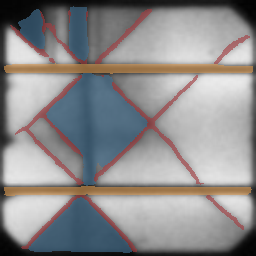

In [17]:
noCell = 27
# Se obtienen las máscaras de las predicciones del modelo.
masks_each = get_masks(masks)
# Se dibujan las máscaras sobre las imágenes originales.
draw_mask(images[noCell], masks_each[noCell])

In [24]:
# 
# Creación de dataframes e imágenes para el reporte

# Creación de imagen de anotaciones `annImage` con las máscaras `crack` y 
# `busbar` de las predicciones
class_values = [0, 10, 100]
for idx, mask in enumerate(masks_each):
    annImage = np.zeros(mask[0].shape, dtype=np.uint8)
    annImage[mask[0]] = class_values[1]  # busbar
    annImage[mask[1]] = class_values[2]  # crack

    annImage = cv.resize(annImage, (images[idx].shape[1], images[idx].shape[0]), 
                         interpolation=cv.INTER_NEAREST)
    cv.imwrite(f'{out_path}/ann/annImage{idx}.png', annImage)
    cv.imwrite(f'{out_path}/image/Image{idx}.png', images[idx])

# Nombres de las clases
class_names = ['busbar', 'crack', 'dark']
# Número de clases en el conjunto de datos
n_classes = 3  

# Generar la imagen del panel completo con las predicciones
panel_prediction_img = combine_panel_predictions(images, masks_each, cols =6)

# Mostrar o guardar la imagen del panel
#panel_prediction_img.show()  
panel_prediction_img.save(f'{out_path}/panel_predictions_mono.png')

# Inicializar una lista para almacenar las estadísticas
stats = []

# Iterar sobre todas las imágenes y usar CrackCell para extraer las estadísticas
for idx in range(len(masks_each)):
    img_path = f'{out_path}/image/Image{idx}.png'
    ann_path = f'{out_path}/ann/annImage{idx}.png'

    # Generar estadísticas de CrackCell
    stats.append(generate_crackcell_stats(img_path, ann_path, crack_inx=100, busbar_inx=10, busbar_num=2))
    

# Convertir la lista de estadísticas en un DataFrame de pandas
crackcell_stats = pd.DataFrame(stats)
# Mostrar el DataFrame
#print(crackcell_stats)
area_statistics = generate_area_percentage_statistics(masks_each, class_names)

generate_defect_bar_chart(area_statistics, f'{out_path}/defect_bar_chart.png')
generate_average_area_bar_chart(area_statistics, f'{out_path}/average_area_bar_chart.png')
generate_crackcell_stats_bar_chart(crackcell_stats, f'{out_path}/crackcell_stats_bar_chart.png')
# Guardar las estadísticas en un archivo CSV
save_statistics(area_statistics, f'{out_path}/area_statistics.csv')
save_statistics(crackcell_stats, f'{out_path}/crackcell_statistics.csv')

# Generar y guardar los mapas de calor de las máscaras predichas
save_heatmap_images(masks_each, out_path)

# Generar la matriz de coocurrencia
cooccurrence_matrix = generate_cooccurrence_matrix(masks_each, n_classes)
plot_cooccurrence_matrix(cooccurrence_matrix, class_names, save_path=f'{out_path}/cooccurrence_matrix.png')

Estadísticas guardadas exitosamente en D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/SalidasMonoV2/area_statistics.csv
Estadísticas guardadas exitosamente en D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/SalidasMonoV2/crackcell_statistics.csv


In [26]:
# Almacena el texto explicativo en variables separadas
intro_mapas_calor = (
    "Un mapa de calor de distribución de predicciones proporciona "
    "una visualización de cómo se presentan los defectos en "
    "las celdas del conjunto de datos, revelando las áreas con mayor "
    "frecuencia de fallos. Este gráfico facilita la identificación "
    "de zonas críticas y patrones de deterioro en el panel fotovoltaico. "
    "Además, permite un monitoreo efectivo del estado del panel a lo "
    "largo del tiempo, apoya la toma de decisiones en el mantenimiento "
    "y ofrece una herramienta útil para la comparación y evaluación "
    "eficiente entre diferentes paneles."
)

intro_cooccurrence_matrix = (
    "Una Matriz de Coocurrencia muestra la frecuencia con la " 
    "que diferentes clases aparecen juntas en las imágenes " 
    "analizadas. Este análisis ayuda a identificar " 
    "posibles interacciones entre las clases, facilitando " 
    "una mejor comprensión del comportamiento de las " 
    "predicciones del modelo y de los defectos en el panel. "
)

intro_crackcell_stats = (
    "La tabla presenta un resumen de las características extraídas de las celdas fotovoltaicas "
    "con defectos. Se incluyen los siguientes parámetros: <br/><br/>"
    "Área Inactiva (%): Muestra el porcentaje de la celda que se considera incapaz de contribuir "
    "efectivamente a la generación de energía. Estas zonas inactivas se definen como aquellas áreas "
    "que están cubiertas por grietas que interrumpen el flujo de corriente, especialmente en las "
    "cercanías de las barras colectoras. A diferencia de las zonas oscuras (Dark) predichas por el "
    "modelo, este indicador se enfoca en las áreas separadas del panel debido a la combinación de grietas "
    "y barras colectoras, permitiendo evaluar la extensión del daño en la celda. <br/><br/>"
    "Longitud de Grieta (píxeles): Mide la longitud total de las grietas presentes en la celda. Esta métrica "
    "permite identificar la severidad del daño estructural en la celda. <br/><br/>"
    "Brillo: Calcula el nivel promedio de brillo en las áreas inactivas de la celda, proporcionando una medida "
    "adicional del estado de deterioro de la celda. Un valor de brillo igual a 1 indica que la celda no presenta "
    "grietas, mientras que valores más bajos podrían sugerir un mayor deterioro. "
)

explain_crackcell_stats = (
    "Para esta tabla primero se obtiene el trazado de las grietas y las barras colectoras, lo que facilita "
    "la medición precisa de la longitud de las grietas. En lugar de considerar todos los píxeles predichos "
    "por el modelo, solo se toman en cuenta aquellos que realmente influyen en la longitud de la grieta. "
    "Además, al combinar esta información con las posiciones de las barras colectoras, se puede estimar las "
    "zonas de la celda que probablemente enfrentarán dificultades para generar energía. "
)

intro_area_statistics = (
    "La tabla de estadísticas generada a partir de las predicciones muestra el porcentaje "
    "de área que ocupa cada clase dentro de cada celda fotovoltaica, en relación con el área "
    "total de la imagen. Los elementos incluidos son: <br/><br/>"
    "Dark [%]: Indica el porcentaje de la imagen cubierto por zonas oscuras. Estas zonas, "
    "visibles en las imágenes de electroluminiscencia (EL), señalan áreas del panel que "
    "están desconectadas y, por lo tanto, no contribuyen a la generación de energía. <br/><br/>"
    "Busbar [%]: Indica el porcentaje de la imagen ocupado por las barras colectoras, " 
    "componentes que transportan la corriente eléctrica generada por la celda. <br/><br/>"
    "Crack [%]: Mide el porcentaje de la imagen afectado por grietas. Las grietas en " 
    "las celdas pueden interrumpir la continuidad eléctrica, afectando la eficiencia del panel."
)

explain_area_statistics = (
    "Para interpretar correctamente esta tabla, se deben analizar los porcentajes de área ocupados "
    "por cada clase en cada imagen. Un porcentaje elevado en la clase `Dark` podría indicar problemas "
    "serios en la funcionalidad de la celda, ya que sugiere que una parte significativa del panel está "
    "inactiva. Un aumento en el porcentaje de `Crack` puede ser un indicio de un deterioro estructural "
    "progresivo de la celda, lo cual podría comprometer su eficiencia. La clase `Busbar` debe mantenerse "
    "estable, y cualquier variación significativa podría indicar problemas en la predicción del modelo o "
    "en la integridad física de las barras colectoras. "
)
panel_predictions_text = (
    "La imagen muestra el panel completo con las imágenes originales y las predicciones superpuestas."
)


In [28]:
## Generación del reporte en PDF
ID_panel = 'Mono2_V40_I5_t28'
fecha_actual = datetime.now().strftime("%Y%m%d")
reporte_pdf = f'{out_path}/reporte_analisis_EL_{fecha_actual}_{ID_panel}.pdf'

# Función para crear una tabla en el PDF
def create_table(dataframe):
    """
    Crea una tabla a partir de un DataFrame de pandas.
    Args:
        dataframe (pd.DataFrame): DataFrame de pandas.
        
    Returns:
        Table: Tabla de reportlab.
    """
    data = [dataframe.columns.tolist()] + dataframe.values.tolist()
    table = Table(data)
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ]))
    return table

# Función para generar el reporte en PDF
def generate_pdf_report():
    pdf = SimpleDocTemplate(reporte_pdf, pagesize=letter)
    elements = []
    styles = getSampleStyleSheet()

    # Crear un estilo de párrafo justificado
    justified_style = ParagraphStyle(
        name='Justified',
        parent=styles['Normal'],
        alignment=TA_JUSTIFY
    )

    # Añadir título
    title = Paragraph("Reporte de Resultados de Análisis de Imágenes EL", styles['Title'])
    elements.append(title)
    elements.append(Spacer(1, 12))

    # Agregar los mapas de calor al PDF
    elements.append(Paragraph("Distribución Espacial de las Predicciones en Mapas de Calor", styles['Heading2']))
    elements.append(Paragraph(intro_mapas_calor, justified_style))
    elements.append(Spacer(1, 12))
    elements.append(Paragraph("Mapa de Calor de Barras Colectoras", styles['Heading3']))
    elements.append(RLImage(f'{out_path}/heatmap_busbar.png', width=200, height=200))
    elements.append(Paragraph("Mapa de Calor de Grietas", styles['Heading3']))
    elements.append(RLImage(f'{out_path}/heatmap_crack.png', width=200, height=200))
    elements.append(Paragraph("Mapa de Calor de Zonas Oscuras", styles['Heading3']))
    elements.append(RLImage(f'{out_path}/heatmap_dark.png', width=200, height=200))
    print(f"Mapas de calor agregados al reporte")

    # Agregar la matriz de coocurrencia al PDF
    elements.append(Paragraph("Matriz de Coocurrencia", styles['Heading2']))
    elements.append(RLImage(f'{out_path}/cooccurrence_matrix.png', width=400, height=300))
    elements.append(Paragraph(intro_cooccurrence_matrix, justified_style))
    elements.append(Spacer(1, 12))
    print(f"Matriz de coocurrencia agregada al reporte")

    # Añadir gráfico de barras de defectos
    elements.append(Paragraph("Gráfico de Barras de Defectos", styles['Heading2']))
    elements.append(Paragraph("Número de Celdas por Clase Predicha", styles['Heading3']))
    elements.append(RLImage(f'{out_path}/defect_bar_chart.png', width=400, height=300))
    print(f"Gráfico de barras de defectos agregado al reporte")

    # Añadir estadísticas de porcentaje de área por imagen
    elements.append(Paragraph("Estadísticas de Porcentaje de Área por Imagen", styles['Heading2']))
    elements.append(Paragraph(intro_area_statistics, justified_style))
    elements.append(Spacer(1, 12))
    elements.append(Paragraph(explain_area_statistics, justified_style))
    elements.append(Spacer(1, 12))
    elements.append(create_table(area_statistics))
    print(f"Estadísticas de Porcentaje de Área por Imagen agregadas al reporte")

    # Añadir gráfico de barras de área promedio
    elements.append(Paragraph("Gráfico de Barras de Área Promedio", styles['Heading2']))
    elements.append(Paragraph("Área Promedio Ocupada por Cada Clase Predicha", styles['Heading3']))
    elements.append(RLImage(f'{out_path}/average_area_bar_chart.png', width=400, height=300))
    print(f"Gráfico de barras de área promedio agregado al reporte")

    # Añadir estadísticas de CrackCell
    elements.append(Paragraph("Estadísticas de CrackCell", styles['Heading2']))
    elements.append(Paragraph(intro_crackcell_stats, justified_style))
    elements.append(Spacer(1, 12))
    elements.append(Paragraph(explain_crackcell_stats, justified_style))
    elements.append(Spacer(1, 12))
    elements.append(create_table(crackcell_stats))
    print(f"Estadísticas de CrackCell agregadas al reporte")

    # Añadir gráfico de barras de estadísticas de CrackCell
    elements.append(Paragraph("Gráfico de Barras de Estadísticas de CrackCell", styles['Heading2']))
    elements.append(Paragraph("Valores Promedio de Estadísticas de CrackCell", styles['Heading3']))
    elements.append(RLImage(f'{out_path}/crackcell_stats_bar_chart.png', width=400, height=300))
    print(f"Gráfico de barras de estadísticas de CrackCell agregado al reporte")
    

    # Añadir la imagen del panel completo con las predicciones
    elements.append(Paragraph("Panel de Predicciones", styles['Heading2']))
    elements.append(Paragraph(panel_predictions_text, justified_style))
    elements.append(RLImage(f'{out_path}/panel_predictions_mono.png', width=500, height=630))
    print(f"Panel de Predicciones agregado al reporte")

    pdf.build(elements)

# Generar el reporte en PDF
generate_pdf_report()
print(f"Reporte PDF generado en: {reporte_pdf}")

Mapas de calor agregados al reporte
Matriz de coocurrencia agregada al reporte
Gráfico de barras de defectos agregado al reporte
Estadísticas de Porcentaje de Área por Imagen agregadas al reporte
Gráfico de barras de área promedio agregado al reporte
Estadísticas de CrackCell agregadas al reporte
Gráfico de barras de estadísticas de CrackCell agregado al reporte
Panel de Predicciones agregado al reporte
Reporte PDF generado en: D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/SalidasMonoV2/reporte_analisis_EL_20240830_Mono2_V40_I5_t28.pdf
